## NARX SST Región Niño 3.4

**PROYECTO:** SISTEMA PARA EL SEGUIMIENTO DE ECOSISTEMAS VENEZOLANOS \
**AUTOR:** Javier Martinez

In [1]:
from MONGO import CONEXION
from datetime import datetime
import pandas as pd
import numpy as np

from tensorflow import keras

# Creando Coenxión con Mongo DB

In [2]:
# Creando la conexión con MongoDB
db = CONEXION.conexion()
db.list_collection_names()

['polygons', 'meteorological', 'SSTNino34']

# Descargando la Información SST NIÑO3.4

In [3]:
# Fecha actual
time = datetime.today().toordinal()

# Realizando consulta
sst_data = db.SSTNino34.find({"time":{"$lte":time}})

# Generando pandas dataframe
data_pandas = pd.DataFrame([file for file in sst_data])
data_pandas['periodo'] = data_pandas.time.apply(lambda x: datetime.fromordinal(x))
data_pandas['mes_year'] =  data_pandas['periodo'].dt.strftime('%B-%Y')
data_pandas.index = pd.to_datetime(data_pandas.periodo)
data_pandas.head(10)

,_id,year,month,nino34_mean,climatologica,anomalias,mes,time,time_actualizacion,periodo,mes_year
periodo,,,,,,,,,,,
2022-06-01,62e6d1d870bebdf1983a27a9,2022,6,26.96,27.73,-0.77,junio,738307,738367,2022-06-01,June-2022
2022-05-01,62e6d1d870bebdf1983a27a8,2022,5,26.82,27.94,-1.12,mayo,738276,738367,2022-05-01,May-2022
2022-04-01,62e6d1d870bebdf1983a27a7,2022,4,26.71,27.83,-1.12,abril,738246,738367,2022-04-01,April-2022
2022-03-01,62e6d1d870bebdf1983a27a6,2022,3,26.32,27.29,-0.98,marzo,738215,738367,2022-03-01,March-2022
2022-02-01,62e6d1d870bebdf1983a27a5,2022,2,25.87,26.76,-0.90,febrero,738187,738367,2022-02-01,February-2022
2022-01-01,62e6d1d870bebdf1983a27a4,2022,1,25.60,26.55,-0.95,enero,738156,738367,2022-01-01,January-2022
2021-12-01,62e6d1d870bebdf1983a27a3,2021,12,25.54,26.60,-1.06,diciembre,738125,738367,2021-12-01,December-2021
2021-11-01,62e6d1d870bebdf1983a27a2,2021,11,25.76,26.70,-0.94,noviembre,738095,738367,2021-11-01,November-2021
2021-10-01,62e6d1d870bebdf1983a27a1,2021,10,25.78,26.72,-0.94,octubre,738064,738367,2021-10-01,October-2021


In [4]:
# Registros
print(data_pandas.shape)
# Data disponible
print(data_pandas.index.min())
print(data_pandas.index.max())

(870, 11)
1950-01-01 00:00:00
2022-06-01 00:00:00


Aplicando transformación

In [5]:
data_pandas.head()

,_id,year,month,nino34_mean,climatologica,anomalias,mes,time,time_actualizacion,periodo,mes_year
periodo,,,,,,,,,,,
2022-06-01,62e6d1d870bebdf1983a27a9,2022,6,26.96,27.73,-0.77,junio,738307,738367,2022-06-01,June-2022
2022-05-01,62e6d1d870bebdf1983a27a8,2022,5,26.82,27.94,-1.12,mayo,738276,738367,2022-05-01,May-2022
2022-04-01,62e6d1d870bebdf1983a27a7,2022,4,26.71,27.83,-1.12,abril,738246,738367,2022-04-01,April-2022
2022-03-01,62e6d1d870bebdf1983a27a6,2022,3,26.32,27.29,-0.98,marzo,738215,738367,2022-03-01,March-2022
2022-02-01,62e6d1d870bebdf1983a27a5,2022,2,25.87,26.76,-0.90,febrero,738187,738367,2022-02-01,February-2022


In [6]:
class LogMinimax:

    @classmethod
    def create(cls, values):

        clase = cls()

        clase.values = values
        clase.log_values = np.log(clase.values)
        clase.max = clase.log_values.max()
        clase.min = clase.log_values.min()

        return clase

    def transformacion(self):

        return (self.log_values - self.min)/(self.max - self.min)

    def inversa(self,y):

        return  np.exp( ( y*(self.max - self.min) ) + self.min )

In [7]:
np.array([0.4,3,4]).std()

1.5173075568988057

In [8]:
class normal_estandar:

    @classmethod
    def create(cls, values):

        clase = cls()

        clase.values = values
        clase.log_values = np.log(clase.values)
        clase.mean = clase.log_values.mean()
        clase.std = clase.log_values.std()

        return clase

    def transformacion(self):

        return (self.log_values - self.mean)/self.std

    def inversa(self,y):

        return  np.exp( (y*self.std) + self.mean  )

In [9]:
# Data modelo
data_model = data_pandas[['nino34_mean']].dropna().copy()

# Transformacion
#transformacion = LogMinimax.create( data_model.nino34_mean.to_numpy() )
transformacion = normal_estandar.create( data_model.nino34_mean.to_numpy() )


data_model['sst'] = transformacion.transformacion()
data_model['sst_exogena'] = transformacion.transformacion()

data_model.head()

,nino34_mean,sst,sst_exogena
periodo,,,
2022-06-01,26.96,0.087820,0.087820
2022-05-01,26.82,-0.054757,-0.054757
2022-04-01,26.71,-0.167305,-0.167305
2022-03-01,26.32,-0.570107,-0.570107
2022-02-01,25.87,-1.042363,-1.042363


Definiendo datos

In [10]:
y_output = 'sst'
exogena = ['sst_exogena']


pd_model = data_model[ [y_output] + exogena].sort_index(ascending=True)
pd_model.head(10)

,sst,sst_exogena
periodo,,
1950-01-01,-2.465417,-2.465417
1950-02-01,-1.902580,-1.902580
1950-03-01,-1.031779,-1.031779
1950-04-01,-0.601339,-0.601339
1950-05-01,-0.705702,-0.705702
1950-06-01,-0.414481,-0.414481
1950-07-01,-0.611757,-0.611757
1950-08-01,-1.031779,-1.031779
1950-09-01,-1.190964,-1.190964


Definiendo clase NARX

In [17]:
from NINO34 import *

prediction_order = 12 # rango de prediccion
auto_order = 35*12 # componente autoregresiva
exog_order = 25*12 # componente exogena qm
exog_delay = 10*12# componente exogena dm


training_model = KERAS_NARX_NINO34(pd_model = pd_model,
                                    y_output = y_output,
                                    exogena = exogena,
                                    prediction_order = prediction_order,
                                    auto_order = auto_order,
                                    exog_order = exog_order,
                                    exog_delay = exog_delay)

# Generando datos para entrenamiento 
training_model.split_data()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 720)]             0         
                                                                 
 dense_5 (Dense)             (None, 1440)              1038240   
                                                                 
 dense_6 (Dense)             (None, 1)                 1441      
                                                                 
Total params: 1,039,681
Trainable params: 1,039,681
Non-trainable params: 0
_________________________________________________________________


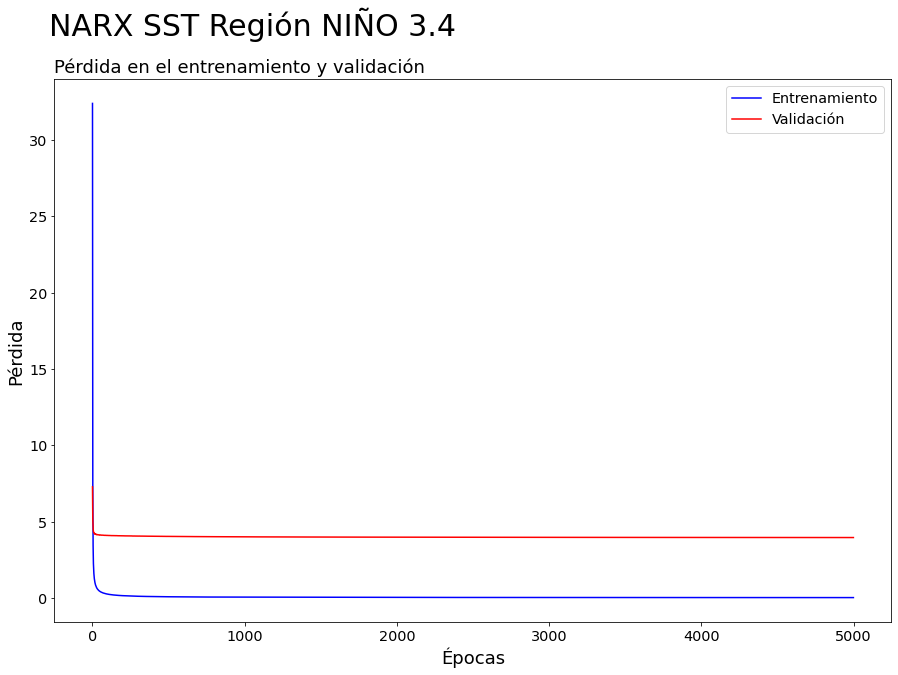

In [23]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

training_model.training_model(layers=[training_model.ninp, 2*training_model.ninp],
                            activation = ['exponential'],
                            kernel_initializer =  ['lecun_normal'],
                            learning_rate = MyLRSchedule(1e-3),
                            loss = "mse",#'mse'
                            metrics = [keras.metrics.MeanSquaredError()],
                            epochs = 5000,
                            batch_size = auto_order,
                            validation_split = 0.20,
                            path_checkpoint = "./model_checkpoint/narx_sst_nino34.h5",
                            patience = 1000,
                            min_delta = 0,
                            monitor = 'val_loss',
                            mode = 'min')

training_model.model.summary()

training_model.loss_plot(title='NARX SST Región NIÑO 3.4',
                        path='./figure/nino34/loss_narx_model_nino34.png')

Validando resultados

<AxesSubplot:>

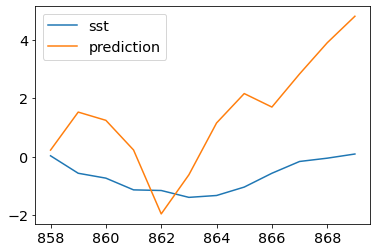

In [24]:
training_model.validation_test(batch_size=32)

training_model.pd_validation[training_model.pd_validation.type=='validation'][[y_output,'prediction']].plot()

In [25]:
pd_summary = training_model.pd_validation.copy()
pd_summary.index = pd.to_datetime(pd_summary.periodo)
pd_summary['nino34_mean'] = pd_summary['sst'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )
pd_summary['prediction_nino34_mean'] = pd_summary['prediction'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )

pd_training = pd_summary[pd_summary.type=='training'].dropna()[['nino34_mean','prediction_nino34_mean']]
training_model.metrics(training_model.class_model.layers,pd_training.nino34_mean,pd_training.prediction_nino34_mean)

{'hidden_layer_sizes': [720, 1440],
 'map': [0.014917780674562477],
 'mae': [0.4073202336703039],
 'rmse': [0.889599633566062],
 'r2': [0.20307349843414413]}

In [26]:
pd_validation = pd_summary[pd_summary.type=='validation'][['nino34_mean','prediction_nino34_mean']]
training_model.metrics(training_model.class_model.layers,pd_validation.nino34_mean,pd_validation.prediction_nino34_mean)

{'hidden_layer_sizes': [720, 1440],
 'map': [0.0860043827406668],
 'mae': [2.2673690984862835],
 'rmse': [2.65557450024285],
 'r2': [-27.139206320950148]}

In [27]:
fig = training_model.graf(data_figure_ajuste=pd_summary[pd_summary.type=='training'],
                        data_figure_validacion=pd_summary[pd_summary.type=='validation'],
                        data_figure_pronostico=pd_summary[pd_summary.type=='self_prediction'],
                        y='nino34_mean',
                        y_predict='prediction_nino34_mean')

fig.write_image('./figure/nino34/pronostico_sstt.png')
fig.show()